In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(42)

In [2]:
import sys
import os

py_file_location = '../utils'
sys.path.append(os.path.abspath(py_file_location))
py_file_location = '../models'
sys.path.append(os.path.abspath(py_file_location))

import wishart_utils
import wishart_models

# Data Preparation

In [3]:
currency_subset_euro_df = pd.read_csv("currencies.csv")
currency_subset_euro_df.head()

,Date,Euro,Swiss Franc,U.K. Pound Sterling,U.S. Dollar,Day,Month,Year
0,1998-10-30,1.18398,1.3459,1.6773,1.0,30,10,1998
1,1998-11-02,1.18373,1.3477,1.6676,1.0,2,11,1998
2,1998-11-03,1.17525,1.3561,1.6552,1.0,3,11,1998
3,1998-11-04,1.17110,1.3689,1.6527,1.0,4,11,1998
4,1998-11-05,1.17706,1.3639,1.6594,1.0,5,11,1998


In [4]:
#plot the covariances for the EURO

covariances_ad = []
covariances_emp = []

for index, row in currency_subset_euro_df.iterrows():
    
    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    #mu_i = z_i.mean()
    mu_i = 0
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    
    covariances_emp.append(x_i)
    covariances_ad.append(x_i[:,0])

In [5]:
covariances_ad = np.array(covariances_ad)

cov_ad_euro = covariances_ad[:,0]
cov_ad_sf = covariances_ad[:,1]
cov_ad_pound = covariances_ad[:,2]
cov_ad_dollar = covariances_ad[:,3]

n_curr = 4

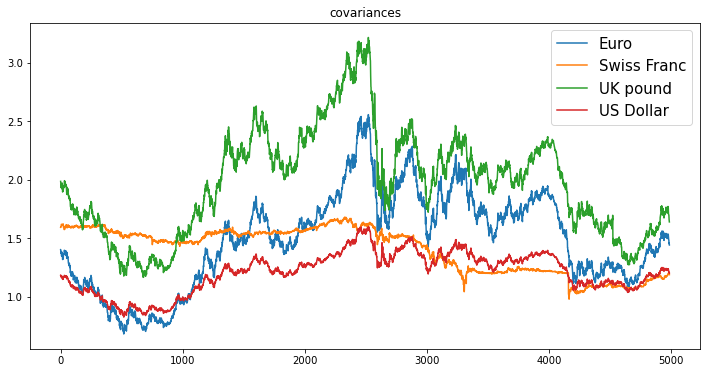

In [6]:
plt.figure(figsize=(12, 6))
legend_size = 15

plt.plot(cov_ad_euro, label="Euro")
plt.plot(cov_ad_sf, label="Swiss Franc")
plt.plot(cov_ad_pound, label="UK pound")
plt.plot(cov_ad_dollar, label="US Dollar")
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

# Create the data for LM(inv. Wishart)+GP

In [7]:
from copy import deepcopy

# specify simple priors
n_0 = 0
Psi_0 = 1 * np.eye(n_curr)

n_i = 0
Psi_i = deepcopy(Psi_0)

selected_points_mu = []
selected_points_cov = []
covs_emp = []
Psis = []
ns = []
mus = [] #compute the means of the values (instead of their covs) for the GWP later on
current_mu = 0

prev_month = 10

for index, row in currency_subset_euro_df.iterrows():
    
    month = row['Month']

    z_i = row[['Euro', 'Swiss Franc', 'U.K. Pound Sterling', 'U.S. Dollar']]
    
    #mu_i = z_i.mean()
    mu_i = 0 
    x_i = np.outer(z_i - mu_i, z_i - mu_i)
    x_i = x_i.astype('float')
    #print("x_i: ", x_i)
    
    #reset when new month starts
    if month != prev_month:
        mus.append(current_mu/n_i)
        #covs_emp.append(Psi_i/n_i)
        covs_emp.append(np.outer(current_mu/n_i, current_mu/n_i))
        current_mu = 0
        
        ns.append(max(n_i, n_curr+1))
        #print("Psi: ", Psi_i)
        Psis.append(Psi_i)
        n_i = n_0
        Psi_i = deepcopy(Psi_0)
        prev_month = month
        
        # add last dates of the months as selected points
        selected_points_mu.append(z_i)
        selected_points_cov.append(x_i)
        
        
    n_i += 1
    #print(np.shape(x_i))
    Psi_i += x_i
    current_mu += z_i

print(len(ns))
print(len(Psis))
print(len(mus))
print(len(selected_points_mu))
print(len(selected_points_cov))

235
235
235
235
235


(235, 4)


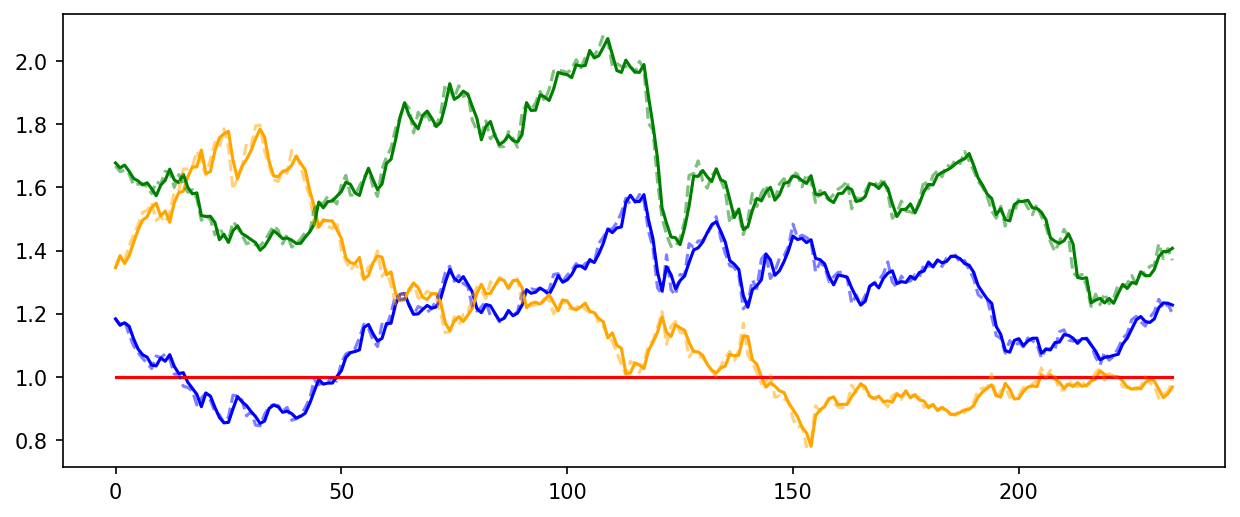

In [8]:
# plot means
print(np.shape(mus))
mus = np.array(mus)
selected_points_mu = np.array(selected_points_mu)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=150)

ax.plot(mus[:,0], color="blue")
ax.plot(mus[:,1], color="orange")
ax.plot(mus[:,2], color="green")
ax.plot(mus[:,3], color="red")
ax.plot(selected_points_mu[:,0], color="blue", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,1], color="orange", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,2], color="green", linestyle="--", alpha=0.5)
ax.plot(selected_points_mu[:,3], color="red", linestyle="--", alpha=0.5)

plt.show();

In [9]:
# get individual mus and Sigmas

Y_mu = []
Y_Sigma = []

t0_LM = time.time()
for i, p_ in enumerate(Psis):
    n_ = ns[i]
    mu_ = wishart_models.Inv_Wishart_sqrtm_bridge_mu(p_, n_)
    Sigma_ = wishart_models.Inv_Wishart_sqrtm_bridge_Sigma(p_, n_)
    Y_mu.append(mu_)
    Y_Sigma.append(Sigma_)

t1_LM = time.time()
print("LM timing: ", t1_LM - t0_LM)

LM timing:  0.06534099578857422


In [10]:
# Select train and test data

train_idxs = np.random.choice(len(Y_mu), int(len(Y_mu)*0.8), replace=False)
train_idxs = np.sort(train_idxs)
bools = torch.ones(len(Y_mu)).bool()
bools[train_idxs] = False
test_idxs = np.arange(len(Y_mu))[bools]
print(len(train_idxs))
print(train_idxs)
print(len(test_idxs))
print(test_idxs)

### chose the right data
Y_mu = np.array(Y_mu)
Y_mu_train = Y_mu[train_idxs]
Y_mu_test = Y_mu[test_idxs]

Y_Sigma = np.array(Y_Sigma)
Y_Sigma_train = Y_Sigma[train_idxs]
Y_Sigma_test = Y_Sigma[test_idxs]

selected_points_mu = np.array(selected_points_mu)
selected_points_mu_train = selected_points_mu[train_idxs]
selected_points_mu_test = selected_points_mu[test_idxs]

selected_points_cov = np.array(selected_points_cov)
selected_points_cov_train = selected_points_cov[train_idxs]
selected_points_cov_test = selected_points_cov[test_idxs]

188
[  0   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40
  41  42  43  44  45  46  47  49  51  53  55  56  59  60  61  62  63  64
  65  66  67  68  69  70  72  73  75  76  77  78  79  80  81  82  83  84
  85  86  89  90  91  93  94  95  96  97  98 100 101 104 105 108 109 110
 111 112 113 114 115 117 118 119 120 122 123 124 125 126 127 128 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 150 152
 153 154 155 156 158 159 161 162 163 164 165 166 167 168 170 171 172 173
 175 176 177 178 180 181 182 183 184 185 186 190 192 195 196 197 198 199
 200 201 204 205 207 208 209 211 212 213 215 216 217 218 219 221 222 223
 224 225 226 228 229 230 232 233]
47
[  1  14  20  21  37  48  50  52  54  57  58  71  74  87  88  92  99 102
 103 106 107 116 121 129 130 149 151 157 160 169 174 179 187 188 189 191
 193 194 202 203 206 210 214 220 227 231 234]


In [11]:
# Prepare the X data

V = np.arange(1, n_curr + 1)

X_train = []
for t in train_idxs:
    for v1 in V:
        for v2 in V:
            X_train.append([t, v1, v2])

X_train = np.array(X_train)            
print(X_train[:25])

X_test = []
for t in test_idxs:
    for v1 in V:
        for v2 in V:
            X_test.append([t, v1, v2])

X_test = np.array(X_test)            
print(X_test[:25])

[[0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 4]
 [0 2 1]
 [0 2 2]
 [0 2 3]
 [0 2 4]
 [0 3 1]
 [0 3 2]
 [0 3 3]
 [0 3 4]
 [0 4 1]
 [0 4 2]
 [0 4 3]
 [0 4 4]
 [2 1 1]
 [2 1 2]
 [2 1 3]
 [2 1 4]
 [2 2 1]
 [2 2 2]
 [2 2 3]
 [2 2 4]
 [2 3 1]]
[[ 1  1  1]
 [ 1  1  2]
 [ 1  1  3]
 [ 1  1  4]
 [ 1  2  1]
 [ 1  2  2]
 [ 1  2  3]
 [ 1  2  4]
 [ 1  3  1]
 [ 1  3  2]
 [ 1  3  3]
 [ 1  3  4]
 [ 1  4  1]
 [ 1  4  2]
 [ 1  4  3]
 [ 1  4  4]
 [14  1  1]
 [14  1  2]
 [14  1  3]
 [14  1  4]
 [14  2  1]
 [14  2  2]
 [14  2  3]
 [14  2  4]
 [14  3  1]]


In [12]:
# build the kernel

def k_SEK(x, x_, s=1, l=3):
    return(s*np.exp(-(x-x_)**2 / (2*l**2)))

def k_RQ(x, x_, s=1, l=10, a=0.1):
    return(s**2 * (1 + (x-x_)**2/(2*a*l**2)))**(-a)

def k_OU(x, x_, s=1, l=9):
    return(s**2 * np.exp(-(np.abs(x-x_)/l)))
    
def k_dirac_soft(x, x_):
    if x == x_:
        return(1)
    else:
        return(0.1)

(3008, 3008)


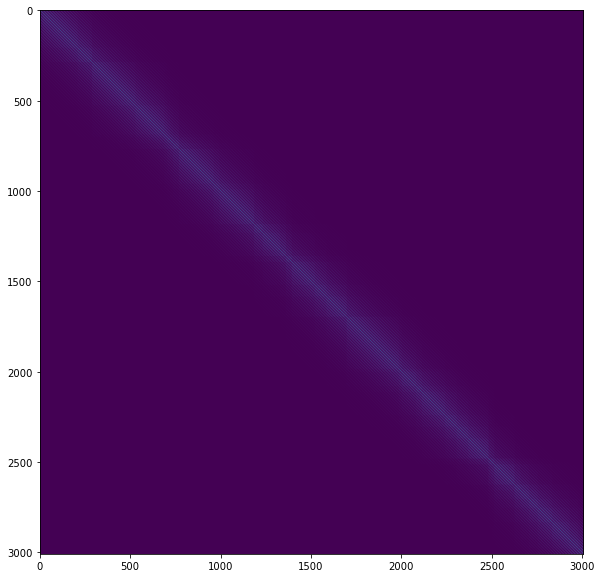

In [13]:

n_train = len(X_train)
K_XX_train = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(n_train):
        t_i = X_train[i,0]
        v1_i = X_train[i,1]
        v2_i = X_train[i,2]
        t_j = X_train[j,0]
        v1_j = X_train[j,1]
        v2_j = X_train[j,2]
        K_XX_train[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)

K_XX_train += 10e-6*np.eye(n_train) #for numerical issues
        
print(np.shape(K_XX_train))

plt.figure(figsize=(10,10))
plt.imshow(K_XX_train)
plt.show();

In [14]:
# prep Y data block

Y_Sigma_block_train = np.zeros((n_train,n_train))
idx = 0
for S in Y_Sigma_train:
    Y_Sigma_block_train[idx:idx+n_curr**2, idx:idx+(n_curr**2)] = S
    idx += n_curr**2

In [15]:
print(wishart_models.is_pos_def(K_XX_train))
print(wishart_models.is_pos_def(Y_Sigma_block_train))

True
True


In [16]:
# calculate GP stuff
from numpy.random import randn, multivariate_normal
from numpy.linalg import cholesky, solve
from scipy.linalg import cho_solve, cho_factor


G_ = K_XX_train + Y_Sigma_block_train
t0_factor = time.time()
G = cho_factor(G_)
t1_factor = time.time()
time_factor = t1_factor - t0_factor
print("time to factor: ", time_factor)

time to factor:  0.5516340732574463


(752, 3008)
(752, 752)


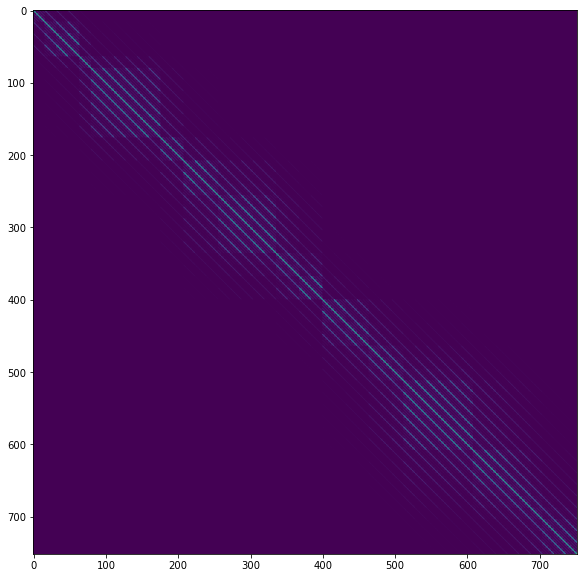

In [17]:
# create x, K_xx, K_xX

n_test = len(X_test)
K_xX = np.zeros((n_test, n_train))
for i in range(n_test):
    for j in range(n_train):
        t_i = X_test[i,0]
        v1_i = X_test[i,1]
        v2_i = X_test[i,2]
        t_j = X_train[j,0]
        v1_j = X_train[j,1]
        v2_j = X_train[j,2]
        K_xX[i, j] = k_OU(t_i, t_j) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)
        
print(np.shape(K_xX))

K_xx = np.zeros((n_test, n_test))
for i in range(n_test):
    for j in range(n_test):
        t_i = X_test[i,0]
        v1_i = X_test[i,1]
        v2_i = X_test[i,2]
        t_j = X_test[j,0]
        v1_j = X_test[j,1]
        v2_j = X_test[j,2]
        K_xx[i, j] = k_OU(t_i, t_j, s=1.002) * k_dirac_soft(v1_i, v1_j) * k_dirac_soft(v2_i, v2_j)


K_xx += np.eye(n_test) * 1e-6

print(np.shape(K_xx))
plt.figure(figsize=(10,10))
plt.imshow(K_xx)
plt.show();

In [18]:
# do some inference
t0_solve = time.time()
A = cho_solve(G, K_xX.T).T
t1_solve = time.time()
time_solve = t1_solve - t0_solve
print("time to solve: ", time_solve)

Y_mu_train = np.array(Y_mu_train).reshape(-1)

out = {}

n_GP_samples = 50

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
t0_mu = time.time()
out["mpost"] = A @ Y_mu_train #m(x) + A @ (Y - mX)  # mean
t1_mu = time.time()
time_mu = t1_mu - t0_mu
print("time to compute mu: ", time_mu)

t0_cov = time.time()
out["vpost"] = K_xx - A @ K_xX.T  # covariance
t1_cov = time.time()
time_cov = t1_cov - t0_cov
print("time to compute Sigma: ", time_cov)

print("time for inference: ", time_factor + time_solve + time_mu + time_cov)

out["spost"] = multivariate_normal(
    out["mpost"].flatten(), out["vpost"], size=n_GP_samples
).T

time to solve:  0.734583854675293
time to compute mu:  0.0010030269622802734
time to compute Sigma:  0.1515798568725586
time for inference:  1.4388008117675781


In [19]:
print(np.shape(out["mpost"]))
print(np.shape(out["vpost"]))
print(np.shape(out["spost"]))

(752,)
(752, 752)
(752, 50)


In [20]:
# transform back and have a look

test_m = out["mpost"].reshape(-1, n_curr, n_curr)
matrices_back = []
for y in test_m:
    y_sqr = y@y.T + np.eye(n_curr) * 10e-8
    #is_pos_def(y_sqr)
    matrices_back.append(y_sqr)
    
test_v = out["vpost"].diagonal().reshape(-1, n_curr, n_curr)
variances_back = []
for v in test_v:
    v_sqr = v@v.T + np.eye(n_curr) * 10e-8
    #is_pos_def(v_sqr)
    variances_back.append(v_sqr)

In [21]:
value_counts = currency_subset_euro_df['Year'].value_counts()

dates = currency_subset_euro_df['Date']
years = currency_subset_euro_df['Year']
euro = currency_subset_euro_df['Euro']
swiss_franc = currency_subset_euro_df['Swiss Franc']
UK_pound = currency_subset_euro_df['U.K. Pound Sterling']
US_dollar = currency_subset_euro_df['U.S. Dollar']

year_idxs = []
idx = 0
for y in range(min(years), max(years)+1):
    year_idxs.append(idx)
    idx += value_counts[y]
    
    
print(year_idxs)

year_labels = years[year_idxs].values
print(year_labels)


[0, 44, 304, 563, 823, 1084, 1343, 1603, 1863, 2122, 2381, 2641, 2900, 3152, 3403, 3652, 3901, 4151, 4401, 4652, 4901]
[1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018]


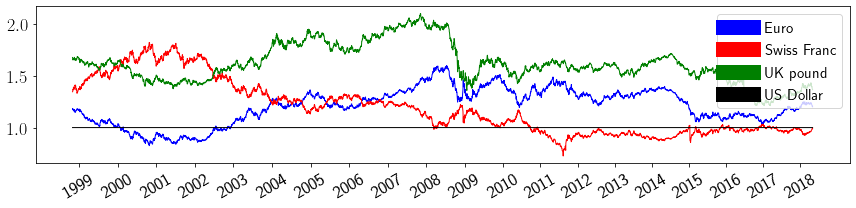

In [22]:
# plot the results

fig = plt.figure(figsize=(12,3))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=18)

lw = 1
legend_size = 15


plt.plot(euro, label="Euro", color='blue', lw=lw)
plt.plot(swiss_franc, label="Swiss Franc", color='red', lw=lw)
plt.plot(UK_pound, label="UK pound", color='green', lw=lw)
plt.plot(US_dollar, label="US Dollar", color='black', lw=lw)

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

leg = plt.legend(prop={'size': legend_size}) 
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(15.0)

plt.tight_layout()
#plt.savefig('figures/currencies.pdf')
plt.show();

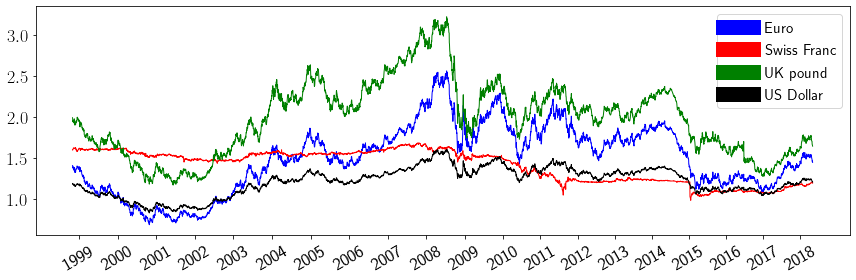

In [23]:
# plot the results

plt.figure(figsize=(12,4))
plt.rc('text', usetex=True)
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=18)

lw = 1
legend_size = 15


plt.plot(cov_ad_euro, label="Euro", color='blue', lw=lw)
plt.plot(cov_ad_sf, label="Swiss Franc", color='red', lw=lw)
plt.plot(cov_ad_pound, label="UK pound", color='green', lw=lw)
plt.plot(cov_ad_dollar, label="US Dollar", color='black', lw=lw)

plt.xticks(year_idxs[1:], year_labels[1:], rotation=30)

leg = plt.legend(prop={'size': legend_size}) 
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(15.0)

plt.tight_layout()
#plt.savefig('figures/currency_covariances.pdf')
plt.show();

In [24]:
matrices_back = np.array(matrices_back)
x1 = matrices_back[:,0,0]
x2 = matrices_back[:,0,1]
x3 = matrices_back[:,0,2]
x4 = matrices_back[:,0,3]

variances_back = np.array(variances_back)
v1 = np.sqrt(variances_back[:,0,0])
v2 = np.sqrt(variances_back[:,0,1])
v3 = np.sqrt(variances_back[:,0,2])
v4 = np.sqrt(variances_back[:,0,3])

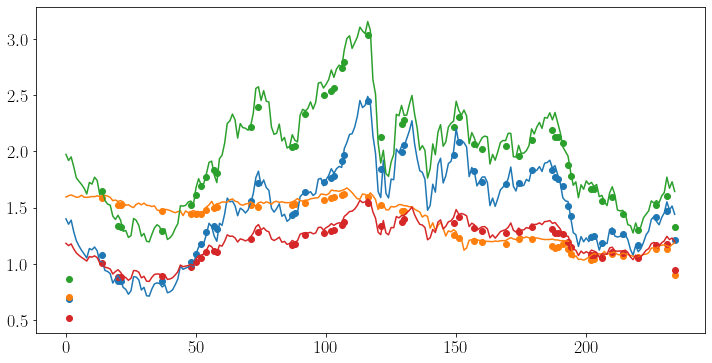

In [25]:
N_test = len(x1)
N_all = 235

fig, ax = plt.subplots(1,1, figsize=(12, 6))

s=1.2
ax.scatter(test_idxs, s*x1)
ax.plot(np.arange(N_all), selected_points_cov[:,0,0])
ax.scatter(test_idxs, s*x2)
ax.plot(np.arange(N_all), selected_points_cov[:,0,1])
ax.scatter(test_idxs, s*x3)
ax.plot(np.arange(N_all), selected_points_cov[:,0,2])
ax.scatter(test_idxs, s*x4)
ax.plot(np.arange(N_all), selected_points_cov[:,0,3])
plt.show();

In [26]:
# put this into numbers

def eval_cov_preds(preds_mean, true, preds_lower, preds_upper):
    
    pred_triu = torch.stack([torch.triu(torch.tensor(x), diagonal=0) for x in preds_mean])
    true_triu = torch.stack([torch.triu(torch.tensor(x), diagonal=0) for x in true])#
    
    #rmse
    rmse = wishart_utils.get_RMSE(pred_triu, true_triu).item()
    # in2std
    preds_lower = torch.tensor(preds_lower)
    preds_upper = torch.tensor(preds_upper)
    true = torch.tensor(true)
    get_in_2_std_ = wishart_utils.get_in_2_std(preds_lower, preds_upper, true)
    return(rmse, get_in_2_std_)

In [27]:
s = 1.2
print(eval_cov_preds(s*matrices_back, selected_points_cov[test_idxs],
                    s*(matrices_back-2*variances_back), s*(matrices_back+2*variances_back)))

(0.12399630083433073, tensor(0.9734))


# Can I remake the same thing with GPyTorch?

In [28]:
import gpytorch

### try with Multitask Kernel

In [29]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=16
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(nu=0.5), num_tasks=16, rank=15
            #gpytorch.kernels.RBFKernel(), num_tasks=16, rank=15
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=16)
model = MultitaskGPModel(torch.tensor(train_idxs).float(), torch.tensor(Y_mu_train).view(len(train_idxs), 16).float(), likelihood)

In [30]:
training_iterations = 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(torch.tensor(train_idxs).float())
    loss = -mll(output, torch.tensor(Y_mu_train).view(len(train_idxs), 16).float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/30 - Loss: 2.081
Iter 2/30 - Loss: 1.978
Iter 3/30 - Loss: 1.883
Iter 4/30 - Loss: 1.798
Iter 5/30 - Loss: 1.722
Iter 6/30 - Loss: 1.651
Iter 7/30 - Loss: 1.584
Iter 8/30 - Loss: 1.523
Iter 9/30 - Loss: 1.462
Iter 10/30 - Loss: 1.398
Iter 11/30 - Loss: 1.328
Iter 12/30 - Loss: 1.255
Iter 13/30 - Loss: 1.181
Iter 14/30 - Loss: 1.110
Iter 15/30 - Loss: 1.044
Iter 16/30 - Loss: 0.980
Iter 17/30 - Loss: 0.919
Iter 18/30 - Loss: 0.854
Iter 19/30 - Loss: 0.785
Iter 20/30 - Loss: 0.712
Iter 21/30 - Loss: 0.635
Iter 22/30 - Loss: 0.555
Iter 23/30 - Loss: 0.481
Iter 24/30 - Loss: 0.422
Iter 25/30 - Loss: 0.371
Iter 26/30 - Loss: 0.321
Iter 27/30 - Loss: 0.269
Iter 28/30 - Loss: 0.207
Iter 29/30 - Loss: 0.135
Iter 30/30 - Loss: 0.062


In [33]:
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.tensor(test_idxs).float()
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
lower = lower.view(-1, 4,4)
upper = upper.view(-1, 4,4)
print(lower.size())

torch.Size([47, 4, 4])


torch.Size([47, 4, 4])


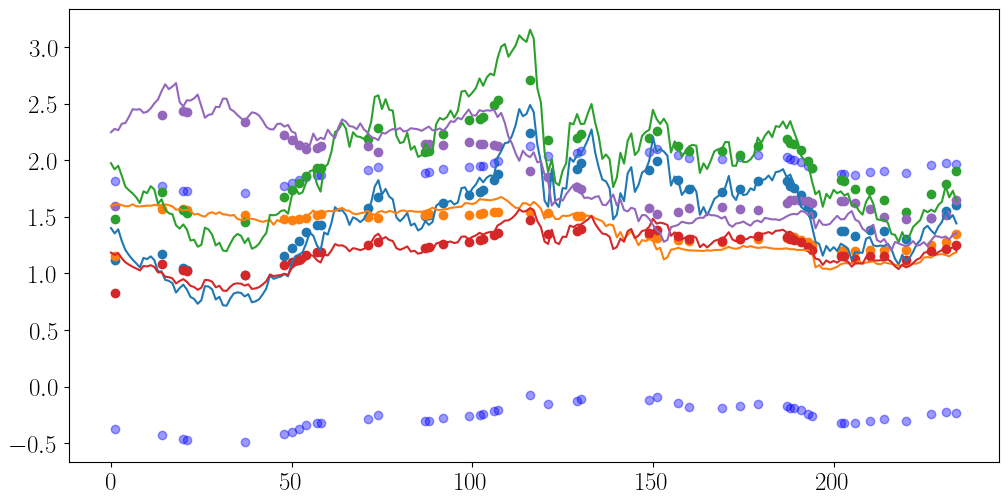

In [34]:
f_mean = mean.view(-1, 4,4)
N_test = len(test_idxs)

f_mean_squared = torch.stack([x.view(4,4) @ x.view(4,4).T for x in f_mean])
print(f_mean_squared.size())

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)

s=1.2 # for some reason the predictions are all off by roughly 1.2
ax.scatter(test_idxs, s*f_mean_squared[:,0,0])
ax.scatter(test_idxs, s*lower[:,0,0], color="blue", alpha=0.4)
ax.scatter(test_idxs, s*upper[:,0,0], color="blue", alpha=0.4)
ax.plot(np.arange(N_all), selected_points_cov[:,0,0])
ax.scatter(test_idxs, s*f_mean_squared[:,1,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,1])
ax.scatter(test_idxs, s*f_mean_squared[:,2,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,2])
ax.scatter(test_idxs, s*f_mean_squared[:,3,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,3])
ax.scatter(test_idxs, s*f_mean_squared[:,1,2])
ax.plot(np.arange(N_all), selected_points_cov[:,1,2])

plt.show();

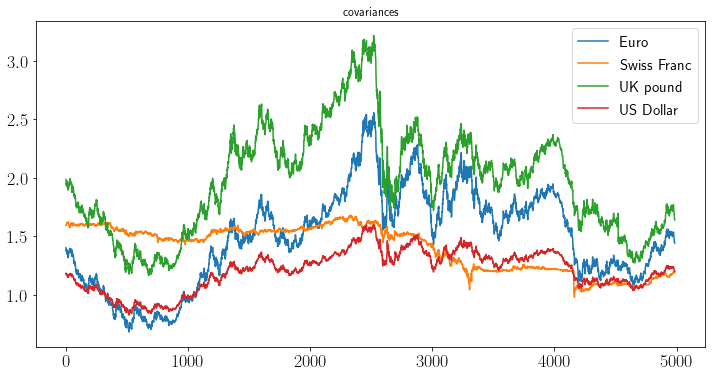

In [35]:
plt.figure(figsize=(12, 6))
legend_size = 15

plt.plot(cov_ad_euro, label="Euro")
plt.plot(cov_ad_sf, label="Swiss Franc")
plt.plot(cov_ad_pound, label="UK pound")
plt.plot(cov_ad_dollar, label="US Dollar")
plt.title("covariances")

plt.legend(prop={'size': legend_size});
plt.show();

In [36]:
# make some numerical comparisons
s=1.2
print(eval_cov_preds(s*f_mean_squared, selected_points_cov[test_idxs],
                    s*(lower), s*(upper)))

(0.12566463566927308, tensor(0.7168))


<ipython-input-26-d7b337f1faa0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_triu = torch.stack([torch.triu(torch.tensor(x), diagonal=0) for x in preds_mean])
<ipython-input-26-d7b337f1faa0>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_lower = torch.tensor(preds_lower)
<ipython-input-26-d7b337f1faa0>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_upper = torch.tensor(preds_upper)


# fit a regular GP on the training data

In [37]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=16
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(nu=0.5), num_tasks=16, rank=15
            #gpytorch.kernels.RBFKernel(), num_tasks=16, rank=15
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=16)
model = MultitaskGPModel(torch.tensor(train_idxs).float(), torch.tensor(selected_points_cov_train).view(len(train_idxs), 16).float(), likelihood)

In [38]:
training_iterations = 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(torch.tensor(train_idxs).float())
    loss = -mll(output, torch.tensor(selected_points_cov_train).view(len(train_idxs), 16).float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/30 - Loss: 2.212
Iter 2/30 - Loss: 2.098
Iter 3/30 - Loss: 2.022
Iter 4/30 - Loss: 1.953
Iter 5/30 - Loss: 1.883
Iter 6/30 - Loss: 1.811
Iter 7/30 - Loss: 1.740
Iter 8/30 - Loss: 1.672
Iter 9/30 - Loss: 1.607
Iter 10/30 - Loss: 1.545
Iter 11/30 - Loss: 1.483
Iter 12/30 - Loss: 1.425
Iter 13/30 - Loss: 1.370
Iter 14/30 - Loss: 1.311
Iter 15/30 - Loss: 1.244
Iter 16/30 - Loss: 1.172
Iter 17/30 - Loss: 1.099
Iter 18/30 - Loss: 1.024
Iter 19/30 - Loss: 0.950
Iter 20/30 - Loss: 0.881
Iter 21/30 - Loss: 0.820
Iter 22/30 - Loss: 0.764
Iter 23/30 - Loss: 0.708
Iter 24/30 - Loss: 0.647
Iter 25/30 - Loss: 0.579
Iter 26/30 - Loss: 0.506
Iter 27/30 - Loss: 0.434
Iter 28/30 - Loss: 0.364
Iter 29/30 - Loss: 0.292
Iter 30/30 - Loss: 0.223


In [39]:
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.tensor(test_idxs).float()
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
lower = lower.view(-1, 4,4)
upper = upper.view(-1, 4,4)

torch.Size([47, 4, 4])


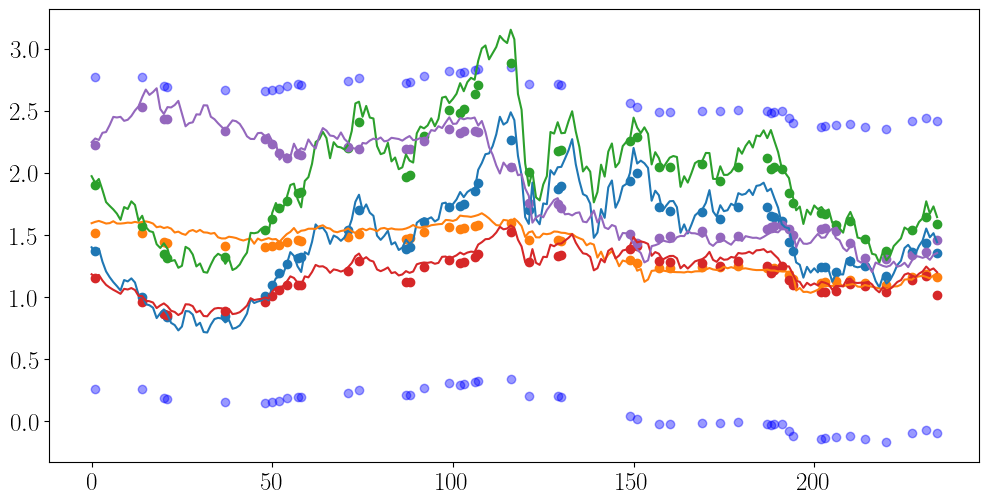

In [40]:
f_mean = mean.view(-1, 4,4)
N_test = len(test_idxs)

print(f_mean_squared.size())

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)

ax.scatter(test_idxs, f_mean[:,0,0])
ax.scatter(test_idxs, upper[:,1,0], color="blue", alpha=0.4)
ax.scatter(test_idxs, lower[:,1,0], color="blue", alpha=0.4)
ax.plot(np.arange(N_all), selected_points_cov[:,0,0])
ax.scatter(test_idxs, f_mean[:,1,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,1])
ax.scatter(test_idxs, f_mean[:,2,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,2])
ax.scatter(test_idxs, f_mean[:,3,0])
ax.plot(np.arange(N_all), selected_points_cov[:,0,3])
ax.scatter(test_idxs, f_mean[:,1,2])
ax.plot(np.arange(N_all), selected_points_cov[:,1,2])

plt.show();

In [41]:
# make some numerical comparisons
s=1.0
print(eval_cov_preds(s*f_mean, selected_points_cov[test_idxs],
                    s*(lower), s*(upper)))

(0.07456254615771313, tensor(1.))


<ipython-input-26-d7b337f1faa0>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_triu = torch.stack([torch.triu(torch.tensor(x), diagonal=0) for x in preds_mean])
<ipython-input-26-d7b337f1faa0>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_lower = torch.tensor(preds_lower)
<ipython-input-26-d7b337f1faa0>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_upper = torch.tensor(preds_upper)


# Compare to Generalized Wishart Process (not working)

The GWP computes for a long time (23h) but I'm not sure if it has already converged. After trying to make it work for a long time, I think the GWP might actually just not work. The fact that the authors never published a final version of the paper gives me some reason to belief that they couldn't make it easier. In any case, drawing samples takes forever and LM works faster and the samples look better.